In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pdb

In [2]:
# colab 전용

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# colab 전용

import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [ ]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
if DEVICE == "cuda":
  torch.cuda.manual_seed_all(1)
else:
  torch.manual_seed(1)

In [ ]:
EPOCHS     = 20
BATCH_SIZE = 16

In [ ]:
trans = transforms.Compose([transforms.Resize((480,640)),
                           transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])
trainset = datasets.ImageFolder(root="./micro", transform = trans)

In [7]:
trainset.__getitem__(10)

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -0.9451],
          [ 1.0000,  1.0000, -0.9529,  ...,  1.0000,  1.0000, -0.9451],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -0.9451],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -0.9451],
          [-1.0000, -0.9529, -0.9529,  ..., -0.9451, -0.9451, -0.9451]],
 
         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -0.9373],
          [ 1.0000,  1.0000, -0.9451,  ...,  1.0000,  1.0000, -0.9373],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -0.9373],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -0.9373],
          [-1.0000, -0.9451, -0.9451,  ..., -0.9373, -0.9373, -0.9451]],
 
         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000,

In [8]:
len(trainset)

303

In [9]:
classes=trainset.classes
classes

['abnormal', 'normal']

In [ ]:
train_loader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = train_loader

In [11]:
train_loader

In [12]:
test_loader

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [14]:
print(labels)

tensor([0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1])


In [15]:
print(images.shape)

torch.Size([16, 3, 480, 640])


In [ ]:
def imshow(img):
    img = img /2 + 0.5 # unnormalize
    np_img = img.numpy()
    # plt.imshow(np_img)
    plt.imshow(np.transpose(np_img, (1,2,0)))
    
    print(np_img.shape)
    print((np.transpose(np_img,(1,2,0))).shape)

(3, 1930, 2570)
(1930, 2570, 3)


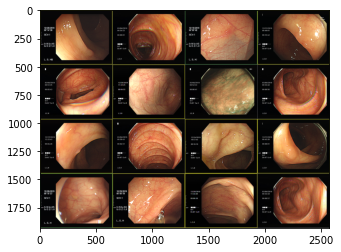

In [17]:
imshow(torchvision.utils.make_grid(images, nrow=4))

In [18]:
print(images.shape)

torch.Size([16, 3, 480, 640])


In [19]:
print((torchvision.utils.make_grid(images)).shape)

torch.Size([3, 966, 5138])


In [20]:
print("".join("%5s "%classes[labels[j]] for j in range(8)))

abnormal normal abnormal abnormal normal abnormal normal normal 


In [ ]:
# ResNet 모델

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__() # == super().__init__()
        self.in_planes = 16

        #self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.linear = nn.Linear(19200, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=0)

In [ ]:
model = ResNet().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=0.0005)
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [ ]:
#print(model)

In [ ]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [27]:
best_test_loss = None
history_e = []
history_l = []
history_a = []
for epoch in range(1, EPOCHS + 1):
    
    train(model, train_loader, optimizer, epoch)
    scheduler.step()
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    history_e.append(epoch)
    history_l.append(test_loss)
    history_a.append(test_accuracy)
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))
    if not best_test_loss or test_loss < best_test_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/micro_resnet_proto.pt')
        best_test_loss = test_loss

[1] Test Loss: 98117051.5644, Accuracy: 50.83%
[2] Test Loss: 8105086.3630, Accuracy: 49.83%
[3] Test Loss: 39319771480.7129, Accuracy: 50.50%
[4] Test Loss: 8851891730.5875, Accuracy: 54.13%
[5] Test Loss: 4561869124.4356, Accuracy: 57.43%
[6] Test Loss: 103349.6502, Accuracy: 99.67%
[7] Test Loss: 0.0000, Accuracy: 100.00%
[8] Test Loss: 0.0000, Accuracy: 100.00%
[9] Test Loss: 556541.4653, Accuracy: 98.68%
[10] Test Loss: 51406.6799, Accuracy: 99.67%
[11] Test Loss: 0.0000, Accuracy: 100.00%
[12] Test Loss: 0.0000, Accuracy: 100.00%
[13] Test Loss: 0.0000, Accuracy: 100.00%
[14] Test Loss: 0.0000, Accuracy: 100.00%
[15] Test Loss: 0.0000, Accuracy: 100.00%
[16] Test Loss: 0.0000, Accuracy: 100.00%
[17] Test Loss: 0.0000, Accuracy: 100.00%
[18] Test Loss: 0.0000, Accuracy: 100.00%
[19] Test Loss: 0.0000, Accuracy: 100.00%
[20] Test Loss: 0.0000, Accuracy: 100.00%


In [ ]:
import matplotlib.pyplot as plt

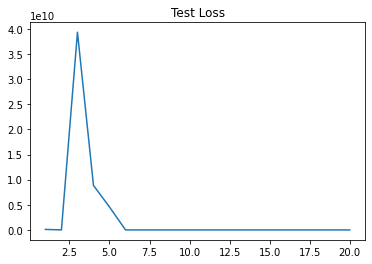

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(history_e, history_l)
plt.title("Test Loss")
plt.figure()
plt.show()

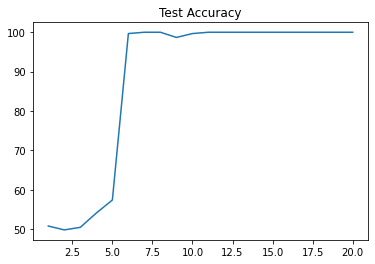

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(history_e, history_a)
plt.title("Test Accuracy")
plt.figure()
plt.show()

In [31]:
#print("Current CPU random seed ", torch.initial_seed())
print("Current CUDA random seed ", torch.cuda.initial_seed())

Current CUDA random seed  1
